In [32]:
import tensorflow as tf
import numpy as np
import tensorflow_addons as tfa

from keras.optimizers import Adam
from keras.initializers import random_normal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils import img_to_array,load_img
from keras.models import load_model

from numpy import asarray
from numpy import load

from random import random
from os import listdir
from matplotlib import pyplot

In [33]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [35]:
device_name = tf.test.gpu_device_name()
if not tf.test.is_gpu_available():
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [36]:
device_name = "/device:GPU:0"

In [6]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(device_lib.list_local_devices())

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2753085656063449155
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5748293632
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8420082514110819545
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [7]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # 使用第一個GPU

In [8]:
def load_images(path, size=(256, 256)):
    data_list = list()
    # enumerate filenames in directory, assume all are images
    for filename in listdir(path):
        # load and resize the image
        pixels = load_img(path + filename, target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)
        # store
        data_list.append(pixels)
    return asarray(data_list)

In [15]:
path = 'Data/'
# load dataset A
dataA1 = load_images(path + 'trainA/')
dataA2 = load_images(path + 'testA/')
dataA = np.vstack((dataA1, dataA2))
print('Loaded dataA: ', dataA.shape)
# load dataset B
dataB1 = load_images(path + 'trainB/')
dataB2 = load_images(path + 'testB/')
dataB = np.vstack((dataB1, dataB2))
print('Loaded dataB: ', dataB.shape)
# save as compressed numpy array
filename = 'd2n.npz'
np.savez_compressed(filename, dataA, dataB)
print('Saved dataset: ', filename)

Loaded dataA:  (823, 256, 256, 3)
Loaded dataB:  (325, 256, 256, 3)
Saved dataset:  d2n.npz


Loaded:  (823, 256, 256, 3) (325, 256, 256, 3)


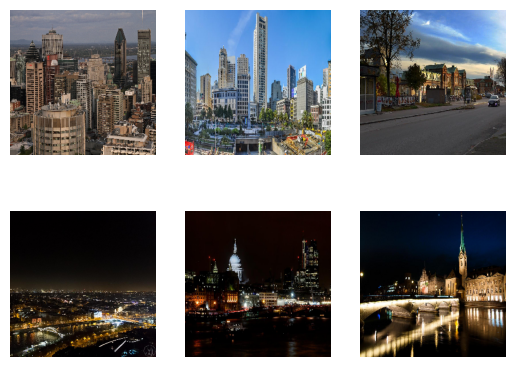

In [16]:
data = load('d2n.npz')
dataA, dataB = data['arr_0'], data['arr_1']
print('Loaded: ', dataA.shape, dataB.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(dataB[i].astype('uint8'))
pyplot.show()

In [38]:
def discriminator(image_shape):
	# weight initialization
	init = random_normal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = tfa.layers.InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = tfa.layers.InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = tfa.layers.InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = tfa.layers.InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model


module = discriminator((256,256,3))
print(module.summary())


Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_96 (Conv2D)          (None, 128, 128, 64)      3136      
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 128, 128, 64)      0         
                                                                 
 conv2d_97 (Conv2D)          (None, 64, 64, 128)       131200    
                                                                 
 instance_normalization_92 (  (None, 64, 64, 128)      256       
 InstanceNormalization)                                          
                                                                 
 leaky_re_lu_26 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                          

In [39]:
# generator a resnet block
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = random_normal(stddev=0.02)
	# first layer convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = tfa.layers.InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = tfa.layers.InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

In [40]:
# define the standalone generator model
def generator(image_shape, n_resnet=9):
	# weight initialization
	init = random_normal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = tfa.layers.InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = tfa.layers.InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = tfa.layers.InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = tfa.layers.InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = tfa.layers.InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = tfa.layers.InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

module = generator((256,256,3))
print(module.summary())

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_102 (Conv2D)            (None, 256, 256, 64  9472        ['input_14[0][0]']               
                                )                                                                 
                                                                                                  
 instance_normalization_96 (Ins  (None, 256, 256, 64  128        ['conv2d_102[0][0]']             
 tanceNormalization)            )                                                          

In [41]:
# define a composite model for updating generators by adversarial and cycle loss
def composite_model(g_model_1, d_model, g_model_2, image_shape):
	# ensure the model we're updating is trainable
	g_model_1.trainable = True
	# mark discriminator as not trainable
	d_model.trainable = False
	# mark other generator model as not trainable
	g_model_2.trainable = False
	# discriminator element
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity element
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# forward cycle
	output_f = g_model_2(gen1_out)
	# backward cycle
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	# define optimization algorithm configuration
	opt = Adam(lr=0.0002, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

In [42]:
# load and prepare training images
def load_real_samples(filename):
	# load the dataset
	data = np.load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = np.ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake instance
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = np.zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [43]:
# save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA):
	# save the first generator model
	filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
	g_model_AtoB.save(filename1)
	# save the second generator model
	filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [45]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, trainX, name, n_samples=5):
	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])
	# save plot to file
	filename1 = '%s_generated_%06d.png' % (name, (step+1))
	pyplot.savefig(filename1)
	pyplot.close()

In [46]:
# update image pool for fake images
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = np.random.randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return np.asarray(selected)


In [1]:
# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):
	# define properties of the training run
	epochs, batch, = 100, 1
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1] # 16
	# unpack dataset
	trainA, trainB = dataset
	# prepare image pool for fakes
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / batch) # 823
	# calculate the number of training iterations
	n_steps = bat_per_epo * epochs # 823 * 100
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		X_realA, y_realA = generate_real_samples(trainA, batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, batch, n_patch)
		# generate a batch of fake samples
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch) # B>A
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch) # A>B
		# update fakes from pool
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)
		# update generator B->A via adversarial and cycle loss
		g_loss2, _, _, _, _ = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -> [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
		# update generator A->B via adversarial and cycle loss
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -> [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
		# summarize performance
		print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		# evaluate the model performance every so often
		if (i+1) % (bat_per_epo * 1) == 0:
			# plot A->B translation
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			# plot B->A translation
			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
		if (i+1) % (bat_per_epo * 5) == 0:
			# save the models
			save_models(i, g_model_AtoB, g_model_BtoA)

In [31]:
dataset = load_real_samples('d2n.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
	# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
	# generator: A -> B
g_model_AtoB = generator(image_shape)
	# generator: B -> A
g_model_BtoA = generator(image_shape)
	# discriminator: A -> [real/fake]
d_model_A = discriminator(image_shape)
	# discriminator: B -> [real/fake]
d_model_B = discriminator(image_shape)
	# composite: A -> B -> [real/fake, A]
c_model_AtoB = composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
	# composite: B -> A -> [real/fake, B]
c_model_BtoA = composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)
	# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

Loaded (823, 256, 256, 3) (325, 256, 256, 3)
1/1 [==============================] - 0s 405ms/step
>1, dA[1.099,0.887] dB[1.054,0.997] g[21.830,20.542]
1/1 [==============================] - 0s 12ms/step
>2, dA[1.287,3.307] dB[3.931,1.313] g[19.322,20.557]
1/1 [==============================] - 0s 16ms/step
>3, dA[1.757,9.686] dB[6.293,1.611] g[21.280,21.940]
1/1 [==============================] - 0s 12ms/step
>4, dA[2.355,5.143] dB[3.688,2.873] g[19.147,29.394]
1/1 [==============================] - 0s 12ms/step
>5, dA[2.010,11.789] dB[3.866,4.002] g[18.693,28.513]
1/1 [==============================] - 0s 12ms/step
>6, dA[1.292,1.576] dB[2.262,2.820] g[17.726,19.643]
1/1 [==============================] - 0s 12ms/step
>7, dA[2.691,1.858] dB[0.811,3.203] g[19.582,25.701]
1/1 [==============================] - 0s 13ms/step
>8, dA[5.470,1.156] dB[1.443,1.619] g[18.673,23.316]
1/1 [==============================] - 0s 13ms/step
>9, dA[2.471,1.136] dB[0.991,1.434] g[19.242,19.447]
1/1 [===

KeyboardInterrupt: 